In [90]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import random # for splitting the dataset randomly
from PIL import Image
from torchvision import transforms


In [91]:
DATA_DIR = "data/stanford_dogs/Images"
OUTPUT_DIR = "data/Processed"
IMG_SIZE = (224, 224)

In [92]:
def load_dataset(data_dir):
    all_paths = glob(os.path.join(data_dir, "*", "*.jpg"))
    all_labels = [os.path.basename(os.path.dirname(p)) for p in all_paths]
    return all_paths, all_labels

# image_paths, labels = load_dataset(DATA_DIR)
# print(f"Found {len(image_paths)} images")

In [93]:
def resize_image(image, target_size=IMG_SIZE):
    """Resize the image to the target size."""
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

In [94]:
def normalize_image(image):
    """Normalize image pixel values to the range [0.0, 1.0]."""
    return image.astype(np.float32) / 255.0

In [95]:

def preprocess_image(path,
                     target_size=IMG_SIZE,
                     to_rgb=True,
                     normalize=True):
    """
    Load and preprocess an image from a given path:
    1) Read image file
    2) Convert BGR to RGB (if enabled)
    3) Resize to target size
    4) Normalize pixel values (if enabled)
    Returns the processed image or None if loading fails.
    """
    img = cv2.imread(path)
    if img is None:
        return None

    if to_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = resize_image(img, target_size)

    if normalize:
        img = normalize_image(img)

    return img

In [ ]:

def apply_color_augmentations(img_np):
    # apply transfomration at p(x) = p, p's chosen to aim to get the best augmneted images to train on
    # can change intensity of these transfromations if needed
    transform = transforms.Compose([
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
        ], p=0.8),

        transforms.RandomGrayscale(p=0.2),

        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=3)
        ], p=0.5),

        transforms.RandomApply([
            transforms.RandomAdjustSharpness(sharpness_factor=2.0)
        ], p=0.5)
    ])

    # to apply transomation, must be PIL image, so convert to PIL image and then convert back
    # to prefered format
    img_uint8 = (np.clip(img_np, 0, 1) * 255).astype(np.uint8)


    pil_img = Image.fromarray(img_uint8)

   
    augmented = transform(pil_img)

    return np.array(augmented) / 255.0 

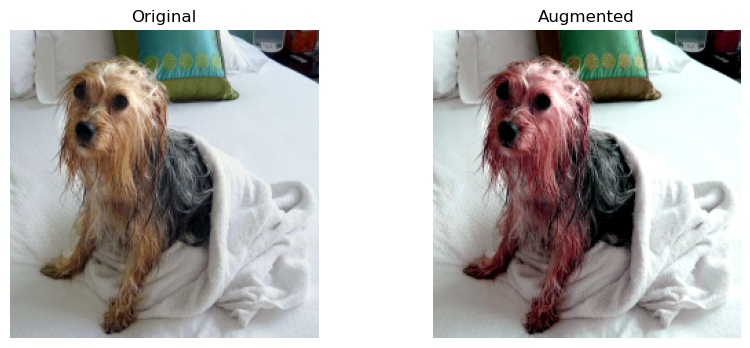

In [ ]:
#TEST FOR APPLY COLOR AUGMENTATIONS
import matplotlib.pyplot as plt

# Re-run this if needed
image_paths, labels = load_dataset(DATA_DIR)
path_to_split = {p: "train" for p in image_paths}  # quick dummy fallback if needed

# Pick a training image
example_path = [p for p in image_paths if path_to_split[p] == "train"][0]
original = preprocess_image(example_path)  # float32 RGB [0,1]

# Apply augmentation
augmented = apply_color_augmentations(original)

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(augmented)
plt.title("Augmented")
plt.axis("off")

plt.show()

In [97]:
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# for path, label in tqdm(zip(image_paths, labels), total=len(image_paths)):
#     image = cv2.imread(path)
#     if image is None:
#         continue
    
#      image = resize_image(image)
#      image = normalize_image(image)
#      image = preprocess_image(image)
    
#     save_path = os.path.join(OUTPUT_DIR, label)
#     os.makedirs(save_path, exist_ok=True)
#     filename = os.path.basename(path)
    
#     save_img = (np.clip(image, 0, 1) * 255).astype(np.uint8)
#     cv2.imwrite(os.path.join(save_path, filename), save_img)
if __name__ == "__main__":
    image_paths, labels = load_dataset(DATA_DIR)
    print(f"Found {len(image_paths)} images")

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Split the ratios:these are the ratios used for 
    # how much each dataset
    SPLIT_RATIOS = {
        "train": 0.7,
        "validation": 0.15,
        "test": 0.15
    }

    # Group paths by class, this ensures that each data split of train test and validation
    # contains examples of all breeds
    class_to_paths = {}
    
    for path, label in zip(image_paths, labels):
        if label not in class_to_paths:
           class_to_paths[label] = [] 
        class_to_paths[label].append(path)

    # assign each path to a split
    path_to_split = {}
    for label, paths in class_to_paths.items(): #for each dogbreed, get all its images
        # randomize the images going into each one by shuffling
        random.shuffle(paths)
        total = len(paths)
        train_end = int(SPLIT_RATIOS["train"] * total)
        val_end = train_end + int(SPLIT_RATIOS["validation"] * total)

        for i, path in enumerate(paths):
            if i < train_end:
                path_to_split[path] = "train"
            elif i < val_end:
                path_to_split[path] = "validation"
            else: #not in train or validation
                path_to_split[path] = "test"
                  

    # Create folders to sepearate train,test,validation data
    for split in SPLIT_RATIOS.keys():
        for label in class_to_paths:
            os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)            

    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths),
                            desc="Preprocessing"):
        img = preprocess_image(path)
        if img is None:
            print(f"[READ FAIL] {path}")  # Warn if the image could not be read
            continue

        split = path_to_split.get(path, "train")
        # apply color augmentation ONLY to training images
        # PUT OTHER AUGMENTATIONS UNDER THIS IF statment
        if split == "train":
           img = apply_color_augmentations(img)
        
        # Convert back to 0–255 and RGB→BGR before saving
        save_img = (img * 255).astype(np.uint8)
        save_img = cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR)

        save_dir = os.path.join(OUTPUT_DIR, split, label)
        os.makedirs(save_dir, exist_ok=True)

        cv2.imwrite(os.path.join(save_dir, os.path.basename(path)), save_img)

Found 20580 images


Preprocessing:   0%|          | 0/20580 [00:00<?, ?it/s]

KeyboardInterrupt: 